In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import joblib
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

import matplotlib.pyplot as plt

df = pd.read_csv("cleaned_hotels_all_months.csv")
df.head()
df.info()
df = pd.get_dummies(df, columns=["Month"])
target_cols = ["Occupancy_Rate", "ADR_Month", "RevPAR_month"]

X = df.drop(columns=["Hotel Name", "Coordinates"] + target_cols)

y = df[target_cols]

print("X shape:", X.shape)
print("y shape:", y.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Hotel Name                   600 non-null    object 
 1   Coordinates                  600 non-null    object 
 2   Rating                       600 non-null    float64
 3   Room Rate                    600 non-null    float64
 4   Competitor density           600 non-null    int64  
 5   Revenue per night            600 non-null    float64
 6   Distance to Closest Station  600 non-null    float64
 7   Property Type                600 non-null    int64  
 8   Avg High Season Rate         600 non-null    float64
 9   Avg Low Season Rate          600 non-null    float64
 10  ADR_Month                    600 non-null    float64
 11  RevPAR_month                 600 non-null    float64
 12  Month                        600 non-null    object 
 13  Occupancy_Rate      

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# global list to store each evaluate() result
ALL_METRICS = []

def evaluate(true, pred, name):
    """
    Computes R2, RMSE, MAE, MAPE for a single target.
    Also stores metrics globally so we can compute overall averages later.
    """
    true = np.array(true)
    pred = np.array(pred)

    # Compute metrics
    r2   = r2_score(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae  = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / np.maximum(np.abs(true), 1e-8))) * 100

    # Print single-target metrics
    print(f"\n{name} metrics:")
    print(f"  R2:   {r2:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  MAE:  {mae:.3f}")
    print(f"  MAPE: {mape:.2f}%")

    # Store metrics for later aggregation
    ALL_METRICS.append({
        "name": name,
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape
    })

    # Also return dictionary
    return {
        "R2": r2, "RMSE": rmse, "MAE": mae, "MAPE": mape
    }


def summarize_all_metrics():
    """
    Computes and prints averages across all evaluate() calls.
    Call this AFTER running evaluate() for Occupancy, ADR, and RevPAR.
    """
    if len(ALL_METRICS) == 0:
        print("No metrics to summarize. Run evaluate() first.")
        return
    
    r2_avg   = np.mean([m["R2"] for m in ALL_METRICS])
    rmse_avg = np.mean([m["RMSE"] for m in ALL_METRICS])
    mae_avg  = np.mean([m["MAE"] for m in ALL_METRICS])
    mape_avg = np.mean([m["MAPE"] for m in ALL_METRICS])

    print("\n====== OVERALL MODEL AVERAGES (all 3 targets) ======")
    print(f"R2_mean:   {r2_avg:.3f}")
    print(f"RMSE_mean: {rmse_avg:.3f}")
    print(f"MAE_mean:  {mae_avg:.3f}")
    print(f"MAPE_mean: {mape_avg:.2f}%")

    return {
        "R2_mean": r2_avg,
        "RMSE_mean": rmse_avg,
        "MAE_mean": mae_avg,
        "MAPE_mean": mape_avg
    }

def regression_metrics(y_true, ypred):
    """
    Compute R², RMSE, MAE, MAPE for multi-output regression.
    Returns metrics averaged across all 3 targets.
    """
    y_true = np.array(y_true)
    y_pred = np.array(ypred)

    r2_list, rmse_list, mae_list, mape_list= [], [], [], []

    for i in range(y_true.shape[1]):
        yt = y_true[:, i]
        yp = y_pred[:, i]

        r2 = r2_score(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))
        mae = mean_absolute_error(yt, yp)
        mape = np.mean(np.abs((yt - yp) / np.maximum(np.abs(yt), 1e-8))) * 100
    

        r2_list.append(r2)
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)

    metrics = {
        "R²_mean": np.mean(r2_list),
        "RMSE_mean": np.mean(rmse_list),
        "MAE_mean": np.mean(mae_list),
        "MAPE_mean": np.mean(mape_list),
    }
    return metrics


In [53]:
## RANDOM FOREST
ALL_METRICS.clear()
rf = RandomForestRegressor(
    n_estimators=400,
    random_state=2025,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

evaluate(y_test["Occupancy_Rate"], y_pred_rf[:, 0], "Occupancy")
evaluate(y_test["ADR_Month"],      y_pred_rf[:, 1], "ADR_Month")
evaluate(y_test["RevPAR_month"],   y_pred_rf[:, 2], "RevPAR")
rf_summary = summarize_all_metrics()
print("Accuracy:", rf.score(X_test, y_test))
rf_metrics = regression_metrics(y_test, y_pred_rf)

joblib.dump(rf, "rf_model.pkl")
print("Saved rf_model.pkl")




Occupancy metrics:
  R2:   0.845
  RMSE: 0.047
  MAE:  0.035
  MAPE: 4.20%

ADR_Month metrics:
  R2:   0.991
  RMSE: 11.095
  MAE:  6.623
  MAPE: 3.16%

RevPAR metrics:
  R2:   0.968
  RMSE: 21.961
  MAE:  13.119
  MAPE: 7.02%

====== OVERALL MODEL AVERAGES (all 3 targets) ======
R2_mean:   0.935
RMSE_mean: 11.034
MAE_mean:  6.592
MAPE_mean: 4.79%
Accuracy: 0.9347113399217509
Saved rf_model.pkl


In [54]:
## XGBOOST
ALL_METRICS.clear()
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    random_state=2025
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

evaluate(y_test["Occupancy_Rate"], y_pred_xgb[:, 0], "XGB Occupancy")
evaluate(y_test["ADR_Month"],      y_pred_xgb[:, 1], "XGB ADR")
evaluate(y_test["RevPAR_month"],   y_pred_xgb[:, 2], "XGB RevPAR")
print("Accuracy", xgb.score(X_test, y_test))
xgb_summary  = summarize_all_metrics()
joblib.dump(rf, "xgb_model.pkl")
print("Saved xgb_model.pkl")



XGB Occupancy metrics:
  R2:   0.993
  RMSE: 0.010
  MAE:  0.006
  MAPE: 0.78%

XGB ADR metrics:
  R2:   0.996
  RMSE: 7.224
  MAE:  3.303
  MAPE: 1.27%

XGB RevPAR metrics:
  R2:   0.991
  RMSE: 11.556
  MAE:  6.014
  MAPE: 2.99%
Accuracy 0.9933957457542419

====== OVERALL MODEL AVERAGES (all 3 targets) ======
R2_mean:   0.993
RMSE_mean: 6.263
MAE_mean:  3.108
MAPE_mean: 1.68%
Saved xgb_model.pkl


In [55]:
## LIGHTGBM


# reset metrics storage
ALL_METRICS.clear()

lgb = LGBMRegressor(random_state=2025, force_col_wise=True, verbosity=-1)

# -------------------------
# 1. Occupancy Rate
# -------------------------
X_train_occ, X_test_occ, y_train_occ, y_test_occ = train_test_split(
    X, y["Occupancy_Rate"], test_size=0.2, random_state=2025
)

lgb.fit(X_train_occ, y_train_occ)
y_pred_occ = lgb.predict(X_test_occ)

evaluate(y_test_occ, y_pred_occ, "LightGBM Occupancy")


# -------------------------
# 2. ADR
# -------------------------
X_train_adr, X_test_adr, y_train_adr, y_test_adr = train_test_split(
    X, y["ADR_Month"], test_size=0.2, random_state=2025
)

lgb.fit(X_train_adr, y_train_adr)
y_pred_adr = lgb.predict(X_test_adr)

evaluate(y_test_adr, y_pred_adr, "LightGBM ADR")


# -------------------------
# 3. RevPAR
# -------------------------
X_train_rev, X_test_rev, y_train_rev, y_test_rev = train_test_split(
    X, y["RevPAR_month"], test_size=0.2, random_state=2025
)

lgb.fit(X_train_rev, y_train_rev)
y_pred_rev = lgb.predict(X_test_rev)

evaluate(y_test_rev, y_pred_rev, "LightGBM RevPAR")


# -------------------------
# 4. Print Overall Averages
# -------------------------
lgbm_summary = summarize_all_metrics() 


# -------------------------
# 5. Save Model
# -------------------------
joblib.dump(lgb, "lgbm_model.pkl")
print("Saved lgbm_model.pkl")



LightGBM Occupancy metrics:
  R2:   0.969
  RMSE: 0.021
  MAE:  0.013
  MAPE: 1.41%

LightGBM ADR metrics:
  R2:   0.990
  RMSE: 11.869
  MAE:  6.364
  MAPE: 2.81%

LightGBM RevPAR metrics:
  R2:   0.965
  RMSE: 22.864
  MAE:  11.617
  MAPE: 5.31%

====== OVERALL MODEL AVERAGES (all 3 targets) ======
R2_mean:   0.974
RMSE_mean: 11.585
MAE_mean:  5.998
MAPE_mean: 3.18%
Saved lgbm_model.pkl


In [56]:
## NEURAL NETWORK MODEL (MLP)

ALL_METRICS.clear()
# Create the Neural Network model
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 64),  # two hidden layers with 64 neurons each
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=42
)

print("Training Neural Network (MLP)...")
mlp.fit(X_train, y_train)

# Predict on test set (shape: n_samples x 3)
y_pred_mlp = mlp.predict(X_test)

# Evaluate each target
evaluate(y_test["Occupancy_Rate"], y_pred_mlp[:, 0], "MLP Occupancy")
evaluate(y_test["ADR_Month"],      y_pred_mlp[:, 1], "MLP ADR")
evaluate(y_test["RevPAR_month"],   y_pred_mlp[:, 2], "MLP RevPAR")

# Print overall averages
mlp_summary  = summarize_all_metrics() 



Training Neural Network (MLP)...

MLP Occupancy metrics:
  R2:   -0.251
  RMSE: 0.134
  MAE:  0.090
  MAPE: 10.60%

MLP ADR metrics:
  R2:   0.997
  RMSE: 6.663
  MAE:  4.035
  MAPE: 1.95%

MLP RevPAR metrics:
  R2:   0.998
  RMSE: 5.974
  MAE:  4.203
  MAPE: 2.41%

====== OVERALL MODEL AVERAGES (all 3 targets) ======
R2_mean:   0.581
RMSE_mean: 4.257
MAE_mean:  2.776
MAPE_mean: 4.99%


In [57]:
# SVM MODEL (SVR)
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

svr_base = SVR(kernel="rbf", C=10, epsilon=0.1)
svr = MultiOutputRegressor(svr_base)

print("\nTraining SVM (SVR with RBF kernel)...")
svr.fit(X_train, y_train)

# Predict on test set (multi-output: columns = [Occupancy, ADR, RevPAR])
y_pred_svr = svr.predict(X_test)

# If you want metrics just for SVR, clear the global list first
ALL_METRICS.clear()

# Per-target evaluation
evaluate(y_test["Occupancy_Rate"], y_pred_svr[:, 0], "SVR Occupancy")
evaluate(y_test["ADR_Month"],      y_pred_svr[:, 1], "SVR ADR")
evaluate(y_test["RevPAR_month"],   y_pred_svr[:, 2], "SVR RevPAR")

# Overall averages across all 3 targets
svr_summary = summarize_all_metrics() 



Training SVM (SVR with RBF kernel)...

SVR Occupancy metrics:
  R2:   0.715
  RMSE: 0.064
  MAE:  0.055
  MAPE: 6.64%

SVR ADR metrics:
  R2:   0.655
  RMSE: 68.744
  MAE:  32.428
  MAPE: 14.14%

SVR RevPAR metrics:
  R2:   0.645
  RMSE: 72.725
  MAE:  31.735
  MAPE: 14.02%

====== OVERALL MODEL AVERAGES (all 3 targets) ======
R2_mean:   0.672
RMSE_mean: 47.178
MAE_mean:  21.406
MAPE_mean: 11.60%


In [58]:
# LSTM MODEL (Keras)

# For LSTM, Keras expects input shape: (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

n_features = X_train.shape[1]
n_outputs  = y_train.shape[1]

# Build the LSTM model
lstm_model = Sequential([
    Input(shape=(1, n_features)),      # timesteps = 1, features = n_features
    LSTM(64, activation='tanh'),       # 64 LSTM units
    Dense(64, activation='relu'),      # dense layer
    Dense(n_outputs)                   # 3 outputs: Occupancy, ADR, RevPAR
])

lstm_model.compile(
    optimizer='adam',
    loss='mse'
)

lstm_model.summary()

# Train the LSTM model
print("\nTraining LSTM model...")
history = lstm_model.fit(
    X_train_lstm, y_train.values,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0  # set to 1 if you want to see training progress
)

# Predict on test set (shape: [n_samples, 3])
y_pred_lstm = lstm_model.predict(X_test_lstm)

# ---- Use your evaluate + summarize pattern ----
ALL_METRICS.clear()

evaluate(y_test["Occupancy_Rate"], y_pred_lstm[:, 0], "LSTM Occupancy")
evaluate(y_test["ADR_Month"],      y_pred_lstm[:, 1], "LSTM ADR")
evaluate(y_test["RevPAR_month"],   y_pred_lstm[:, 2], "LSTM RevPAR")

lstm_summary = summarize_all_metrics()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,115 (102.01 KB)

 Trainable params: 26,115 (102.01 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

LSTM Occupancy metrics:
  R2:   -5.246
  RMSE: 0.299
  MAE:  0.229
  MAPE: 26.24%

LSTM ADR metrics:
  R2:   0.973
  RMSE: 19.202
  MAE:  12.243
  MAPE: 5.87%

LSTM RevPAR metrics:
  R2:   0.960
  RMSE: 24.388
  MAE:  13.791
  MAPE: 8.06%

====== OVERALL MODEL AVERAGES (all 3 targets) ======
R2_mean:   -1.104
RMSE_mean: 14.630
MAE_mean:  8.755
MAPE_mean: 13.39%


In [59]:
## RIDGE REGRESSION

ALPHA = 1.0  # you can tune this

ridge_base = Ridge(alpha=ALPHA)
ridge = MultiOutputRegressor(ridge_base)

print("\nTraining Ridge Regression (multi-output)...")
ridge.fit(X_train, y_train)

# Predict on test set
y_pred_ridge = ridge.predict(X_test)

# Evaluate per target using your evaluate() helper
ALL_METRICS.clear()

evaluate(y_test["Occupancy_Rate"], y_pred_ridge[:, 0], "Ridge Occupancy")
evaluate(y_test["ADR_Month"],      y_pred_ridge[:, 1], "Ridge ADR")
evaluate(y_test["RevPAR_month"],   y_pred_ridge[:, 2], "Ridge RevPAR")

ridge_summary = summarize_all_metrics()


Training Ridge Regression (multi-output)...

Ridge Occupancy metrics:
  R2:   0.957
  RMSE: 0.025
  MAE:  0.021
  MAPE: 2.39%

Ridge ADR metrics:
  R2:   0.993
  RMSE: 9.466
  MAE:  6.951
  MAPE: 4.38%

Ridge RevPAR metrics:
  R2:   0.963
  RMSE: 23.618
  MAE:  16.655
  MAPE: 11.80%

====== OVERALL MODEL AVERAGES (all 3 targets) ======
R2_mean:   0.971
RMSE_mean: 11.036
MAE_mean:  7.875
MAPE_mean: 6.19%


In [60]:
results = pd.DataFrame([
    ["Random Forest",        rf_summary["R2_mean"],   rf_summary["RMSE_mean"],
                             rf_summary["MAE_mean"],  rf_summary["MAPE_mean"]],
    ["XGBoost",              xgb_summary["R2_mean"],  xgb_summary["RMSE_mean"],
                             xgb_summary["MAE_mean"], xgb_summary["MAPE_mean"]],
    ["LightGBM",             lgbm_summary["R2_mean"], lgbm_summary["RMSE_mean"],
                             lgbm_summary["MAE_mean"],lgbm_summary["MAPE_mean"]],
    ["Neural Network (MLP)", mlp_summary["R2_mean"],  mlp_summary["RMSE_mean"],
                             mlp_summary["MAE_mean"], mlp_summary["MAPE_mean"]],
    ["SVM (SVR)",            svr_summary["R2_mean"],  svr_summary["RMSE_mean"],
                             svr_summary["MAE_mean"], svr_summary["MAPE_mean"]],
    ["LSTM (Keras)",         lstm_summary["R2_mean"], lstm_summary["RMSE_mean"],
                             lstm_summary["MAE_mean"],lstm_summary["MAPE_mean"]],
    ["Ridge Regression",     ridge_summary["R2_mean"], ridge_summary["RMSE_mean"],
                             ridge_summary["MAE_mean"],ridge_summary["MAPE_mean"]]
],
    columns=["Model", "R2_mean", "RMSE_mean", "MAE_mean", "MAPE_mean"]
)

display(results.round(4))


,Model,R2_mean,RMSE_mean,MAE_mean,MAPE_mean
0,Random Forest,0.9347,11.0344,6.5924,4.7921
1,XGBoost,0.9934,6.2632,3.1077,1.6775
2,LightGBM,0.9744,11.5848,5.9982,3.1767
3,Neural Network (MLP),0.5810,4.2568,2.7762,4.9861
4,SVM (SVR),0.6717,47.1777,21.4061,11.6009
5,LSTM (Keras),-1.1042,14.6299,8.7547,13.3901
6,Ridge Regression,0.9712,11.0364,7.8753,6.1915


In [61]:
#  PREDICT ON FAKE HOTELS (ALL MODELS)

# Make 2 sample hotels with semi-realistic values
fake_hotels = pd.DataFrame([
    {
        "Rating": 4.2,
        "Room Rate in USD": 220,
        "Competitor density": 3000,
        "Distance to Closest Station (km)": 0.3,
        "Property Type (Star Rating)": 4,
        "Avg High Season Rate": 260,
        "Avg Low Season Rate": 180,
        **{col: X[col].mean() for col in X.columns if col not in [
            "Rating", "Room Rate in USD", "Competitor density",
            "Distance to Closest Station (km)", "Property Type (Star Rating)",
            "Avg High Season Rate", "Avg Low Season Rate"
        ]}
    },
    {
        "Rating": 4.8,
        "Room Rate in USD": 400,
        "Competitor density": 6000,
        "Distance to Closest Station (km)": 0.1,
        "Property Type (Star Rating)": 5,
        "Avg High Season Rate": 500,
        "Avg Low Season Rate": 300,
        **{col: X[col].mean() for col in X.columns if col not in [
            "Rating", "Room Rate in USD", "Competitor density",
            "Distance to Closest Station (km)", "Property Type (Star Rating)",
            "Avg High Season Rate", "Avg Low Season Rate"
        ]}
    }
])

# reorder columns exactly like training set
fake_hotels = fake_hotels[X.columns]

# scale
fake_scaled = scaler.transform(fake_hotels)

# LSTM needs (samples, timesteps, features)
fake_lstm = fake_scaled.reshape((fake_scaled.shape[0], 1, fake_scaled.shape[1]))

# Predictions for XGBoost
fake_pred_xgb   = xgb.predict(fake_scaled)


# Display output
for i in range(fake_hotels.shape[0]):
    print(f"\n========================")
    print(f"Fake Hotel #{i+1}")
    print("========================")
    display(fake_hotels.iloc[i:i+1])

    print("\nPredictions:")
    
    def show_preds(name, preds):
        print(f"\n{name}:")
        print(f"  Occupancy Rate: {preds[i][0]:.2f}")
        print(f"  ADR Month:      {preds[i][1]:.2f}")
        print(f"  RevPAR Month:   {preds[i][2]:.2f}")

    show_preds("XGBoost",         fake_pred_xgb)



Fake Hotel #1


,Rating,Room Rate,Competitor density,Revenue per night,Distance to Closest Station,Property Type,Avg High Season Rate,Avg Low Season Rate,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
0,4.2,230.4,3000,44627.86,0.4324,3.46,260,180,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333



Predictions:

XGBoost:
  Occupancy Rate: 0.85
  ADR Month:      198.89
  RevPAR Month:   181.39

Fake Hotel #2


,Rating,Room Rate,Competitor density,Revenue per night,Distance to Closest Station,Property Type,Avg High Season Rate,Avg Low Season Rate,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
1,4.8,230.4,6000,44627.86,0.4324,3.46,500,300,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333



Predictions:

XGBoost:
  Occupancy Rate: 0.86
  ADR Month:      293.80
  RevPAR Month:   270.71


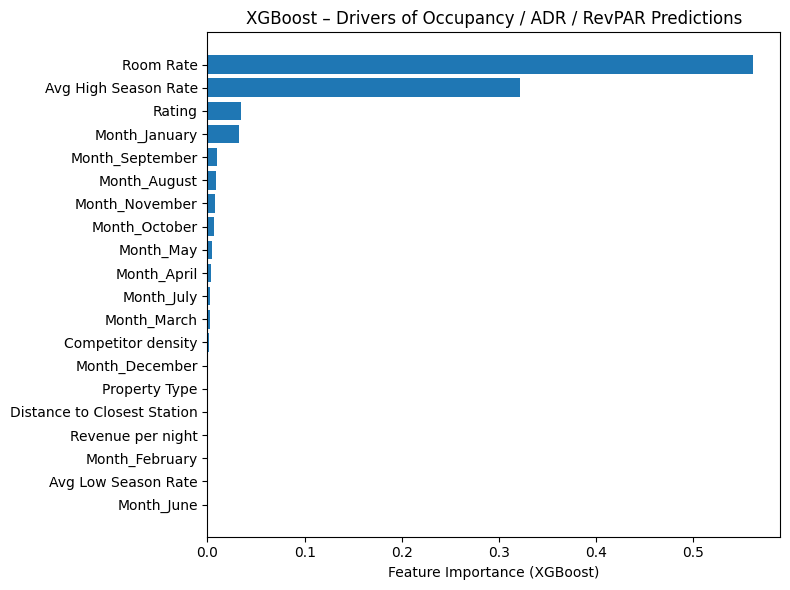

In [67]:
## XGBOOST ANALYSIS
# xgb.feature_importances_ has one importance per input feature
importances = xgb.feature_importances_

fi_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values("importance", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.xlabel("Feature Importance (XGBoost)")
plt.title("XGBoost – Drivers of Occupancy / ADR / RevPAR Predictions")
plt.tight_layout()
plt.show()
